In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
import os
import json
from collections import OrderedDict

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import h5py
import dill
from tqdm import tqdm
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.interpolate import interp1d


In [20]:
from agnfinder.prospector import main, load_photometry
from agnfinder import photometry_to_table
from agnfinder.tf_sampling import deep_emulator

In [23]:
os.chdir('/home/walml/repos/agnfinder')

In [4]:
DATA_ROOT = '/home/walml/repos/agnfinder/data'

We'll construct a catalog with magnitudes (and errors) like the catalog loaded here

In [5]:
parquet_loc = os.path.join(DATA_ROOT, 'photometry_quicksave.parquet')  # should be df with loaded photometry in maggies

In [6]:
df = pd.read_parquet(parquet_loc)

In [8]:
bands = df.columns.values[:12]
errors = df.columns.values[12:]
# 11 bands, hardcoded for now
bands, errors

(array(['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
        'VISTA_J', 'VISTA_Ks', 'VISTA_Y', 'VISTA_Z', 'wise_w1', 'wise_w2'],
       dtype=object),
 array(['u_sloan_err', 'g_sloan_err', 'r_sloan_err', 'i_sloan_err',
        'z_sloan_err', 'VISTA_H_err', 'VISTA_J_err', 'VISTA_Ks_err',
        'VISTA_Y_err', 'VISTA_Z_err', 'wise_w1_err', 'wise_w2_err'],
       dtype=object))

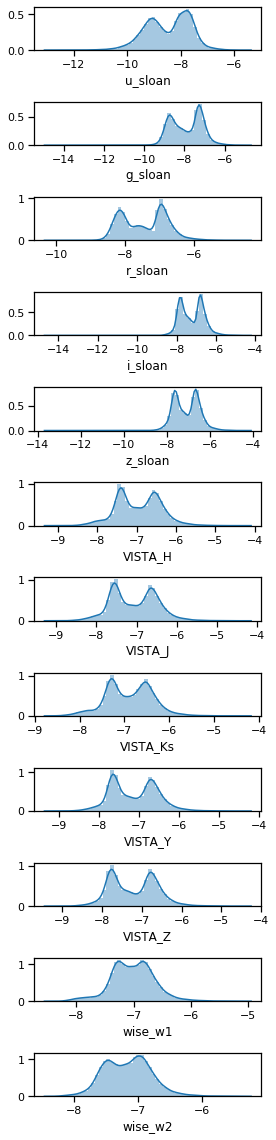

In [13]:
# bimodal because of the high-z QSO, presumably
fig, axes = plt.subplots(nrows=len(bands), figsize=(4, 16))
for n, band in enumerate(bands):
    ax = axes[n]
    sns.distplot(np.log10(df[band]), ax=ax)
fig.tight_layout()

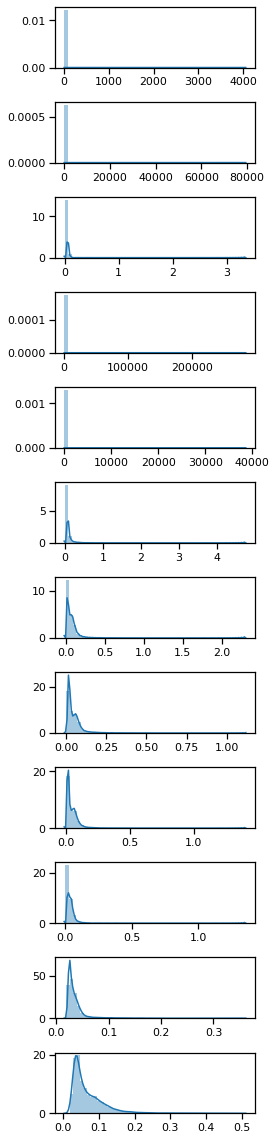

In [106]:
# bimodal because of the high-z QSO, presumably
fig, axes = plt.subplots(nrows=len(bands), figsize=(4, 16))
for n, band in enumerate(bands):
    ax = axes[n]
    sns.distplot(df[errors[n]]/df[band], ax=ax)
fig.tight_layout()

Let's do the same but now recording the distributions, rather than automatically with seaborn

In [14]:
from scipy.stats import gaussian_kde

In [17]:
kdes = {}
for band in bands:
    kdes[band] = gaussian_kde(np.log10(df[band]))

In [96]:
with open(os.path.join(DATA_ROOT, 'cpz_maggie_kdes.pickle'), 'wb') as f:
    dill.dump(kdes, f)

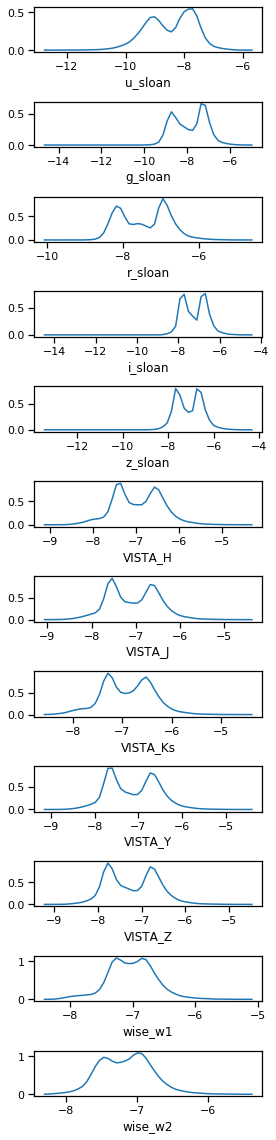

In [19]:
fig, axes = plt.subplots(nrows=len(bands), figsize=(4, 16))
for n, band in enumerate(bands):
    ax = axes[n]
    x = np.linspace(np.log10(df[band].min()), np.log10(df[band].max()))
    ax.plot(x, kdes[band](x))
    ax.set_xlabel(band)
fig.tight_layout()

Great. Let's test that we can sample a non-random grid using pairwise matching

- draw a set of maggies from the kdes above (all bands)
- find the galaxy in the cube with the most similar maggies (code already exists)
- select that galaxy (and do not select again)

These cube galaxies will have different underlying parameters (we can't know these for real galaxies) but will be observationally identical

But hmm - the bands are highly dependent on each other (see notes).
Sampling from marginals != sampling from joint!

Instead, let's be simple:
- pick a real galaxy
- find the synthetic pair, do not pick again

In [21]:
cube_dir = 'data/cubes/latest'

In [24]:
_, _, x_test, y_test = deep_emulator.data(cube_dir)

In [25]:
x_test.shape, y_test.shape

((30000, 9), (30000, 8))

In [45]:
bands

array(['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
       'VISTA_J', 'VISTA_Ks', 'VISTA_Y', 'VISTA_Z', 'wise_w1', 'wise_w2'],
      dtype=object)

In [46]:
euclid_bands = ['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
       'VISTA_J', 'VISTA_Y']

In [47]:
output_dim = 8
n_galaxies = 1000


In [58]:
limits = {}
for band in bands:
    limits[band] = (np.percentile(df[band], 2), np.percentile(df[band], 98))

In [59]:
limits  # linear space but that's fine, is a ranking

{'u_sloan': (6.5410895014061e-11, 8.121924364833195e-08),
 'g_sloan': (7.04303143842984e-10, 3.0696939204275316e-07),
 'r_sloan': (3.444630715096574e-09, 6.243473242170609e-07),
 'i_sloan': (6.3568040033624485e-09, 8.757945401403468e-07),
 'z_sloan': (7.839919154004205e-09, 1.1504258588554516e-06),
 'VISTA_H': (8.487976157471445e-09, 1.4389820847431788e-06),
 'VISTA_J': (7.719758417351446e-09, 1.1777138698078975e-06),
 'VISTA_Ks': (1.0575165812786188e-08, 1.3078903149552918e-06),
 'VISTA_Y': (7.186055732172683e-09, 1.027450222290552e-06),
 'VISTA_Z': (6.401912232908261e-09, 8.546161944802898e-07),
 'wise_w1': (1.3314936694868921e-08, 5.969164322907937e-07),
 'wise_w2': (1.4597886693457979e-08, 4.1341800010434234e-07)}

In [65]:
df_clipped = df.copy()
for band in bands:
    lower_lim = limits[band][0]
    upper_lim = limits[band][1]
    df_clipped = df.query(f'{band} > {lower_lim}').query(f'{band} < {upper_lim}')

In [66]:
len(df), len(df_clipped)

(31986, 30706)

In [67]:
all_photometry = -np.log10([row for _, row in df_clipped[euclid_bands].iterrows()])

In [68]:
all_photometry.shape

(30706, 8)

In [69]:
all_photometry[0]

array([7.74911675, 7.26959715, 7.0986786 , 6.96364296, 6.89713388,
       6.90098792, 6.94194476, 6.93118196])

In [70]:
y_test[0]

array([8.22100481, 7.86341715, 7.75048109, 7.69283167, 7.54132465,
       6.90057098, 7.2872301 , 7.45523754])

In [71]:
# best_thetas = np.zeros((n_galaxies, output_dim))
# best_norm_theta = np.zeros((n_galaxies, output_dim))
pairs = []
for n, photometry in tqdm(enumerate(all_photometry), total=len(all_photometry)):
    error = np.sum((photometry - y_test) ** 2, axis=1)
    best_index = np.argmin(error) # equivalent to an MLE in discrete space
    pairs.append(best_index)
#     best_thetas[n] = theta[best_params_index]
#     best_norm_theta[n] = norm_theta[best_params_index]

100%|██████████| 30706/30706 [00:23<00:00, 1324.26it/s]


In [72]:
pd.value_counts(pairs)

23030    579
15382    466
10686    374
23019    369
11123    365
        ... 
29526      1
15231      1
15247      1
27541      1
20490      1
Length: 2636, dtype: int64

In [89]:
pd.Series(pairs).duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
30701     True
30702    False
30703     True
30704     True
30705     True
Length: 30706, dtype: bool

In [83]:
f = (pd.value_counts(pairs) < 2).values

In [91]:
pairs_without_duplicates = np.array(pairs)[~pd.Series(pairs).duplicated()]

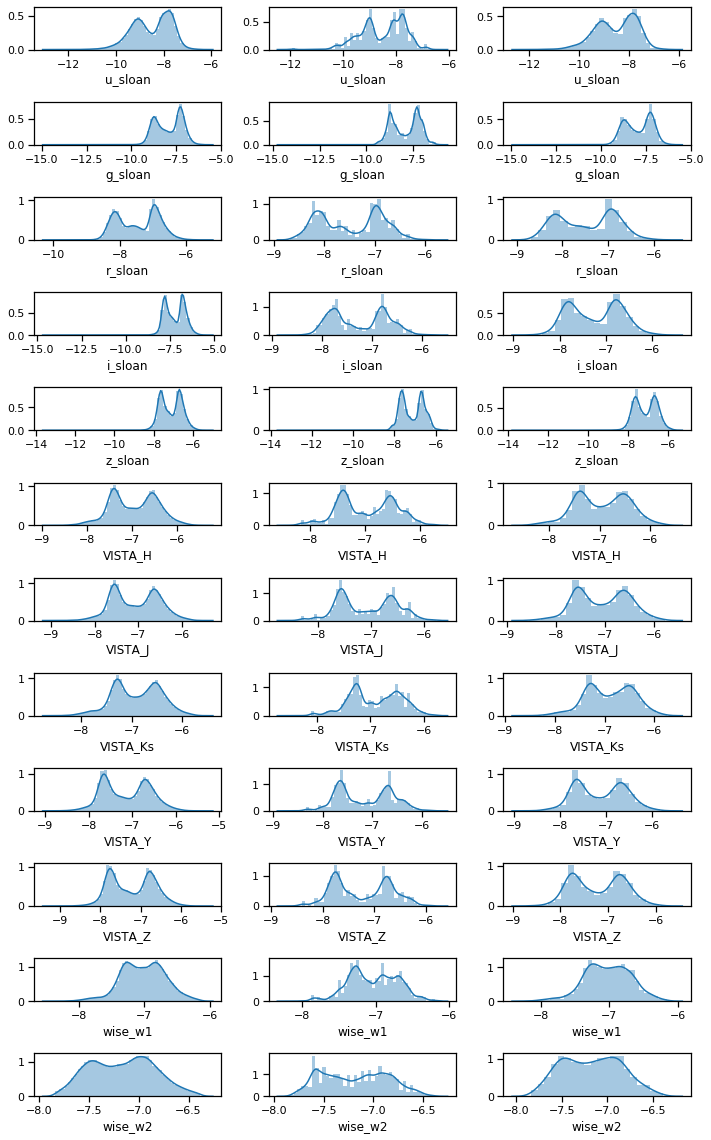

In [92]:
df_sampled = df_clipped.iloc[pairs]
df_single = df_clipped.iloc[pairs_without_duplicates]
fig, axes = plt.subplots(nrows=len(bands), ncols=3, figsize=(10, 16))
for n, band in enumerate(bands):
    row = axes[n]
    sns.distplot(np.log10(df_clipped[band]), ax=row[0])
    sns.distplot(np.log10(df_sampled[band]), ax=row[1])
    sns.distplot(np.log10(df_single[band]), ax=row[2])
fig.tight_layout()

In [94]:
len(df_clipped), len(df_sampled), len(df_single)

(30706, 30706, 2636)

Convert the whole thing to a function

In [101]:
def find_closest_galaxies(input_rows: np.array, candidates: np.array):
    pairs = []
    for n, photometry in tqdm(enumerate(input_rows), total=len(input_rows)):
        error = np.sum((photometry - candidates) ** 2, axis=1)
        best_index = np.argmin(error) # equivalent to an MLE in discrete space
        pairs.append(best_index)
    return pairs


def select_subsample(photometry_df: pd.DataFrame, cube_y: np.array, duplicates=False):
    
    bands = ['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
       'VISTA_J', 'VISTA_Y']  # euclid
    assert cube_y.shape[1] == len(bands)
    
    # trim real photometry outliers
    limits = {}
    for band in bands:
        limits[band] = (np.percentile(photometry_df[band], 2), np.percentile(photometry_df[band], 98))
    df_clipped = df.copy()
    for band in bands:
        lower_lim = limits[band][0]
        upper_lim = limits[band][1]
        df_clipped = photometry_df.query(f'{band} > {lower_lim}').query(f'{band} < {upper_lim}')

    all_photometry = -np.log10([row for _, row in df_clipped[bands].iterrows()])
    
    pairs = find_closest_galaxies(all_photometry, cube_y)
    if duplicates:
        return pairs
    else:
        duplicated = ~pd.Series(pairs).duplicated(keep='first')
        pairs_without_duplicates = np.array(pairs)[~duplicated]
        return pairs_without_duplicates



In [102]:
pairs = select_subsample(df, y_test)

100%|██████████| 30706/30706 [00:23<00:00, 1300.48it/s]


In [103]:
len(pairs)

2530